## Javier Peralta
Podemos usar múltiples técnicas para interpretar la  los datos recien publicados para el estudio de felicidad del 2018, el cual usa datos del 2017. Comenzamos cargando los datos

In [1]:
library("gdata")
require(kohonen)
library(maptools)
data(wrld_simpl)
data = read.xls('WHR2018Chapter2OnlineData.xls', sheet=1)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: kohonen
Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


Los datos traen información para cada año, así que filtramos los del 2017 

In [2]:
# Separamos los datos que usaremos
data2018 = data[data[, 'year'] == 2017,]
# Usamos el nombre del pais como nombre de columna
row.names(data2018) <- data2018[,1]
datanames<-data2018[,1]

También quitamos las columnas que corresponden al año y al nombre del pais ya que este lo tenemos como nombres de las filas y puede causar problemas en nuestros algoritmos al no ser un dato numérico

In [3]:
data2018.filtered <- 
    data2018[,colSums(is.na(data2018)) < nrow(head(data2018))][-1][-1]

También es necesario escalar los datos, ya que no queremos que el parámetro con sea dominante al momento de agrupar o proyectar. 

In [4]:
data2018.scaled <- scale(data2018.filtered)

Primero visualizaremos los resultados de *Self Organizing Map*, este pone en *cubetas* a los datos que sean similares, y las cubetas cercanas tienen datos más similares que las lejanas

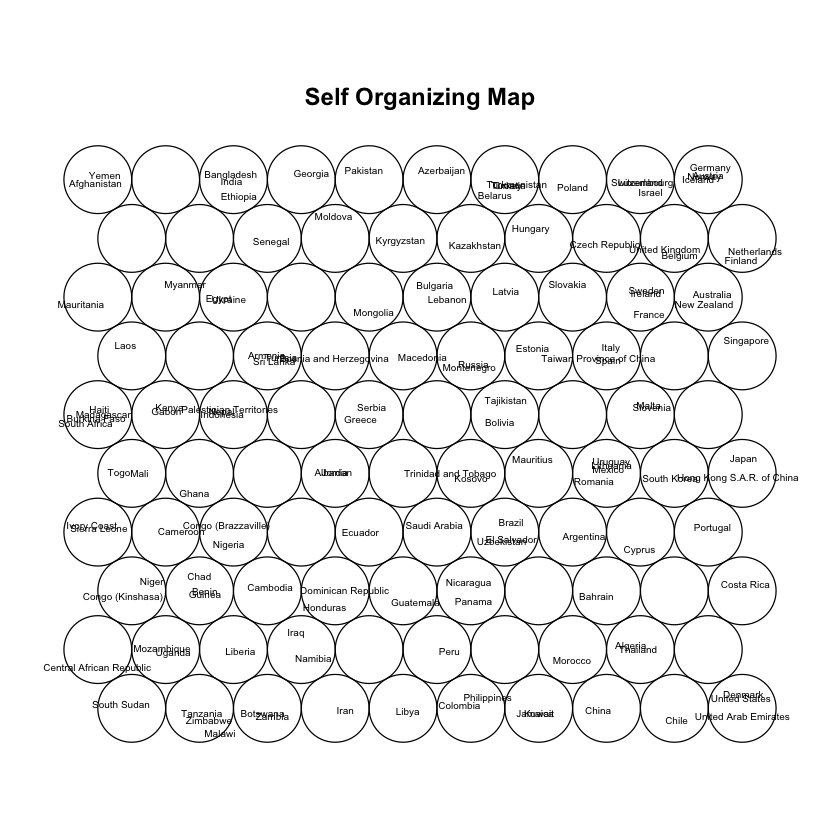

In [5]:
sz = 10
data2018.som <- som(data2018.scaled, 
                    grid = somgrid(xdim = sz, ydim=sz, topo="hexagonal"))
plot(data2018.som, type = "mapping", main = "Self Organizing Map", 
     labels=rownames(data2018.scaled), cex=0.5, font=1)

Es importante recordar que en SOM el orden no es importante, sólo las distancias. Aun que es un poco dificil de leer, podemos ver que varios paises Europeos se encuentran cerca, en la esquina inferior derecha, y los paises latinoamericanos se encuentran principalmente en el centro. Aún con esta visualización es dificil ver grupos como tal, por lo que intentaremos un método de clustering.

Escojemos *Agrupamiento Jerárquico* ya que este no nos pide saber nada a priori.

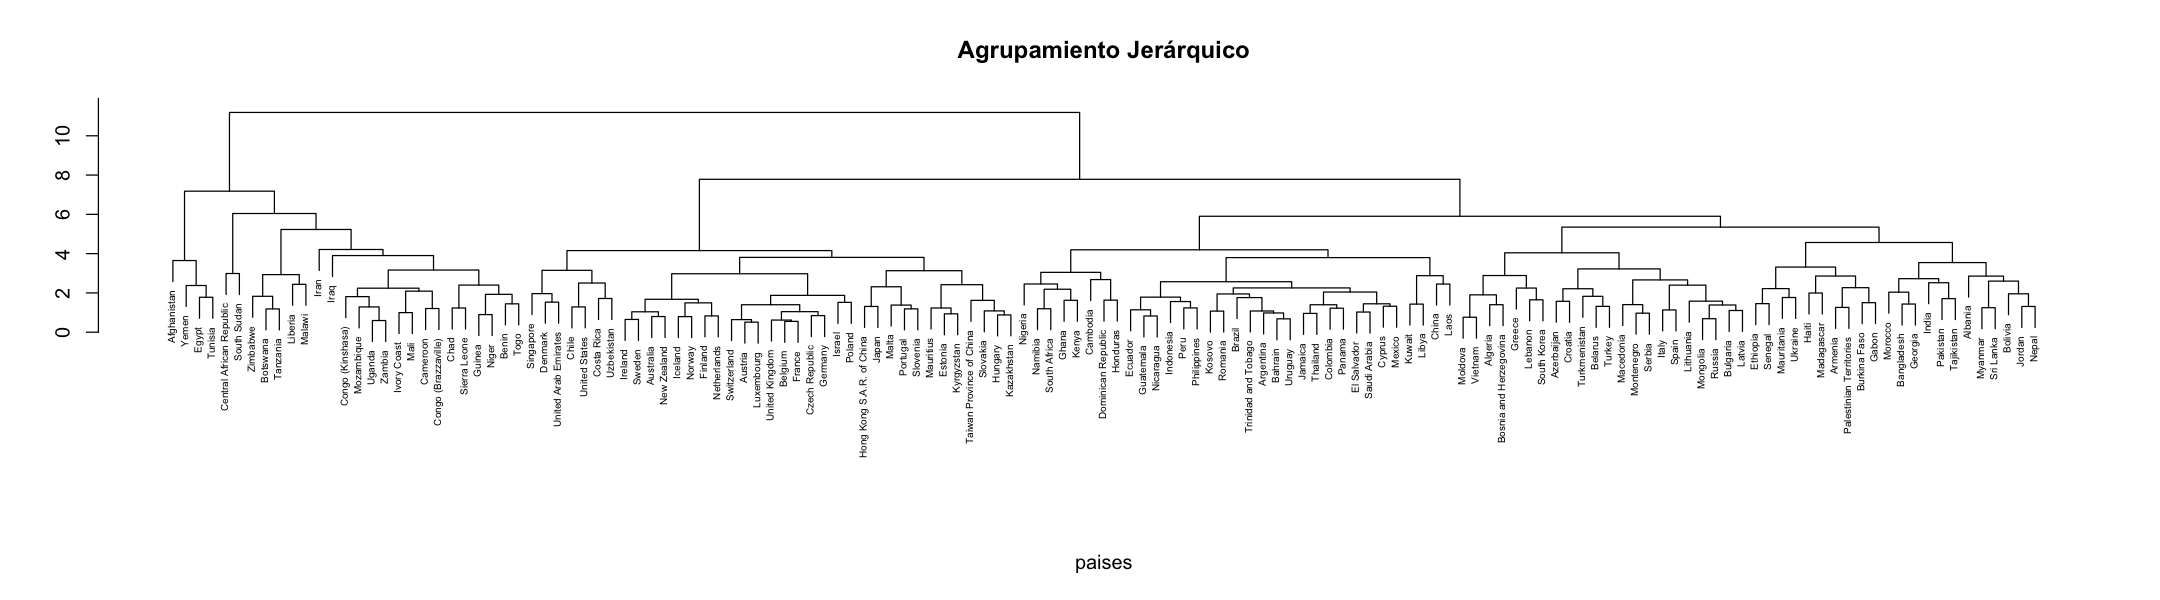

In [6]:
library(repr)
options(repr.plot.width=18, repr.plot.height=5)
data2018.hc <- hclust(dist(data2018.scaled))
plot(data2018.hc, ylab="", xlab='paises', main='Agrupamiento Jerárquico',
     sub="", cex=0.5)
options(repr.plot.width=10, repr.plot.height=10)

Ya que tenemos muchos paises, es dificil de ver que paises están en que grupos, pero lo que sí podemos ver es la cantidad de grupos que hay. Se alcanza a distinguír que principalmente hay dos grupos, aun que facilmente podríamos tomar cuatro, seis u ocho. Para facilitar su visualización coloreamos los paises en un mapa según su grupo. El color negro representa que no hay datos para esos paises.

In [7]:
groupcolors <- function(datatree, num_grups){ #función para colorear los grupos
    myCountries = wrld_simpl@data$NAME %in% datatree[datatree[,"group"] == 1,][,1]
    for (i in 2:num_grups){
     myCountries = myCountries + i*wrld_simpl@data$NAME 
        %in% datatree[datatree[,"group"] == i,][,1]
    }
    return(myCountries + 1)
}

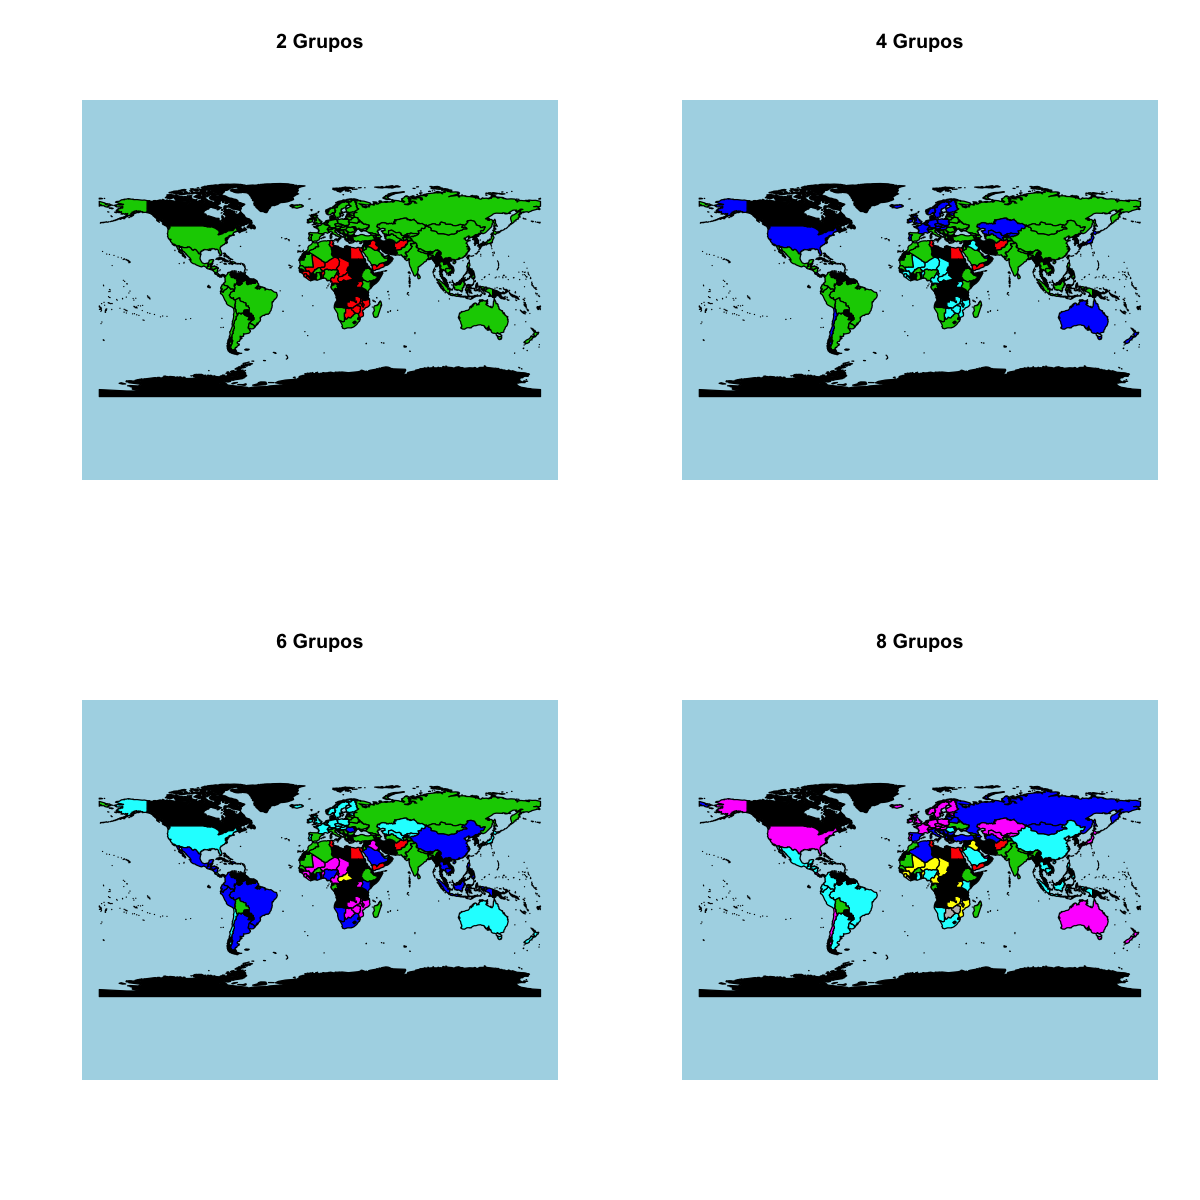

In [8]:
par(mfrow = c(2,2))
for (i in seq(2,8,2)){
    data2018.memb <- cbind(matrix(data2018[, 1]), cutree(data2018.hc, k = i))
    colnames(data2018.memb) <- c('country', 'group')
    plot(wrld_simpl, col = groupcolors(data2018.memb, i), bg="lightblue", 
         main=paste(c(i, "Grupos"), collapse = " ") )
}

Cuando tomamos dos grupos, es muy claro que varios paises afircanos son muy distintos, en cuanto a felicidad, al resto del mundo, esto podría estar ligado a la cantidad de conflictos armados y escases de alimentos que se vive en dichos paises. 

Al usar cuatro grupos podemos ver una separación extra muy calara, donde los azules representan a los paises *primer mundistas*, con la excepción de Kazajastán, también en rójo podemos ver paises como Egipto, Yemen y Afgánistan, paises que se encuentran en conliftos armados, en 6 y 8 sólo vemos a más detalla la diferencia entre latino-américa, Rusia y algunos paises africanos.

Finalmente, podríamos tomar los datos del estudio del 2017, con datos tomados en el 2016, y comparar contra los datos del 2018. Para hacer eso filtramos los datos de igual manera y mantenemos sólo las columnas que tenemos en 2018. También agregamos el sufijo *_2017* para poder distinguír los datos.

In [9]:
data2017 = data[data[, 'year'] == 2016,]
row.names(data2017) <- paste(data2017[,1], "2017", sep="_")
data2017.filtered <- data2017[,colSums(is.na(data2018)) < nrow(head(data2018))][-1][-1]
data2017.scaled <- scale(data2017.filtered)

In [10]:
head(data2017.scaled)

,Life.Ladder,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Positive.affect,Negative.affect,Standard.deviation.of.ladder.by.country.year,Standard.deviation.Mean.of.ladder.by.country.year,gini.of.household.income.reported.in.Gallup..by.wp5.year
Afghanistan_2017,-1.03387496,-2.0207658,-1.4189454,-1.8756688,-1.4773942,0.6885227,-0.80384682,0.01105186,-0.3095898
Albania_2017,-0.77880726,-1.3867250,0.7299352,-0.2597716,-0.3651169,0.3958271,1.18803270,1.04329075,-0.3300015
Algeria_2017,-0.05134157,-0.5062503,0.3012758,NA,-0.5137007,1.0048899,-0.05826049,-0.17932450,1.5075749
Argentina_2017,0.90110479,0.5664516,0.5421045,0.6593344,1.3156672,0.2852454,-0.02885450,-0.59566719,-1.1553004
Armenia_2017,-0.94155287,-0.8208741,0.2315664,-1.1862746,-1.1884852,1.6657270,-0.03059786,0.43378023,-0.6717372
Australia_2017,1.62252623,1.0420650,1.2116597,1.2410771,0.8009482,-0.5453724,-1.03195269,-1.21494827,0.6897695


Podríamos concatenar los datos, hacer PCA sobre ellos y ver de que forma cambiaron al graficar sobre los dos primeros componentes. Para hacer PCA es necesario imputar los datos faltantes. Una técnica que podríamos usar es remplazar con la media o la mediana de la columna. En este caso usaremos la media.

In [11]:
library(randomForest)
data1718 <- rbind(data2017.filtered, data2018.filtered) #concatena datos sin centrar
data1718.fixed <- scale(na.roughfix(data1718)) #remplaza faltantes con media y centramos

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gdata’:

    combine



In [12]:
p <- prcomp(data1718.fixed)
summary(p)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2472 1.2870 0.78982 0.69371 0.62217 0.57535 0.50097
Proportion of Variance 0.5611 0.1840 0.06931 0.05347 0.04301 0.03678 0.02789
Cumulative Proportion  0.5611 0.7451 0.81446 0.86793 0.91094 0.94772 0.97561
                           PC8     PC9
Standard deviation     0.42800 0.19065
Proportion of Variance 0.02035 0.00404
Cumulative Proportion  0.99596 1.00000

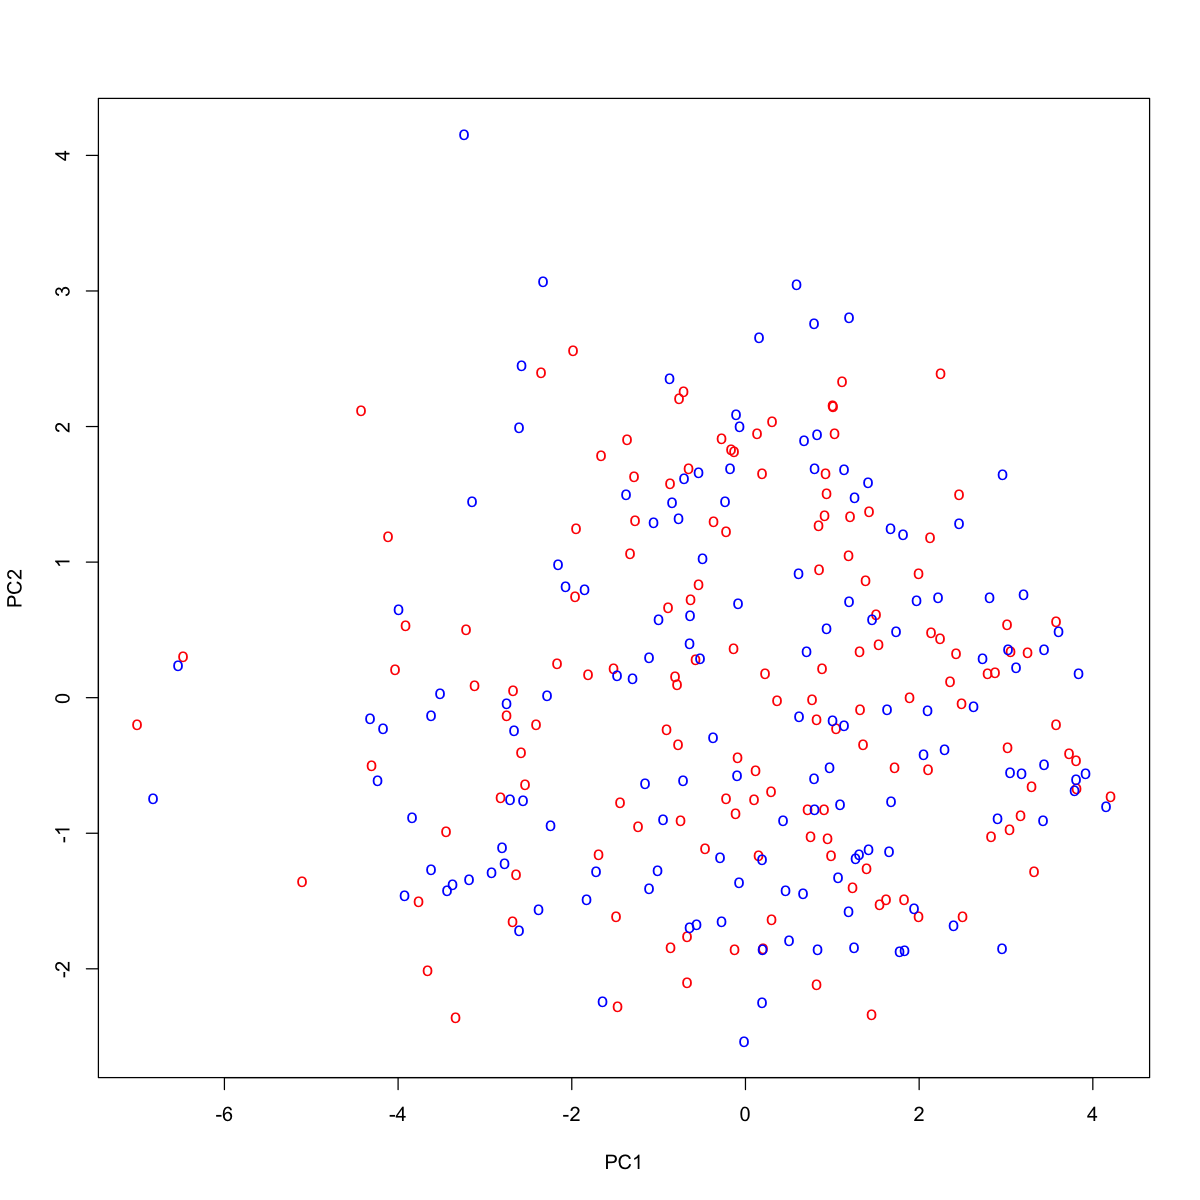

In [13]:
plot(p$x[,1], p$x[,2], ylab="PC2", xlab="PC1", pch="o",
     col=c(rep(2, nrow(data2017.scaled)), rep(4, nrow(data2018.scaled))) )

En rojo graficamos los datos del 2017 y en azul los del 2018, visualmente es dificil saber si en verdad hay una diferencia. Sobre el primer componente parecieran iguales, pero sobre el segundo no. Podemos usar los promedios para ver si hay una diferencia.

In [14]:
data1718.d2017 <- data1718.fixed[1:nrow(data2017.scaled),]
data1718.d2018 <- data1718.fixed[1:nrow(data2018.scaled),]
                   
data2017.mean <- colMeans(data1718.d2017)
data2018.mean <- colMeans(data1718.d2018)

In [15]:
means <- rbind(data2017.mean,data2018.mean)

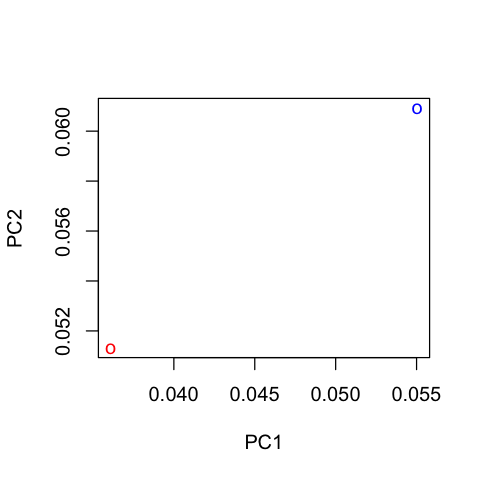

In [16]:
options(repr.plot.width=4, repr.plot.height=4)
meanProy <- means %*% p$rotation[,c('PC1', 'PC2')]
plot(meanProy[,1], meanProy[,2], ylab="PC2", xlab="PC1", pch="o", col=c(2,4))

Aun que la escala es diminuta y posiblemente neglegible, en promedio los paises en 2018 son más felices.